In [1]:
# imports
import numpy as np
from pylab import *
from preprocessing import get_preprocessed_data
from features import find_peaks
import audioFeatureExtraction

In [2]:
x_dataA, y_labelA, framerate_A = get_preprocessed_data('A', N=2, factor=10)

x_dataB, y_labelB, framerate_B = get_preprocessed_data('B', N=2, factor=5)

In [10]:
# get peaks for A
dataA_peaks = find_peaks(x_dataA, 'A')

'''n = 50
figure()
title(y_labelA[n])
plot(x_dataA[n],'b')
scatter(dataA_peaks[n],x_dataA[n][dataA_peaks[n]],c='r')
show()'''

"n = 50\nfigure()\ntitle(y_labelA[n])\nplot(x_dataA[n],'b')\nscatter(dataA_peaks[n],x_dataA[n][dataA_peaks[n]],c='r')\nshow()"

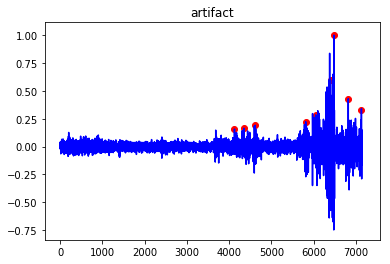

In [11]:
n = 2
figure()
title(y_labelA[n])
plot(x_dataA[n],'b')
scatter(dataA_peaks[n],x_dataA[n][dataA_peaks[n]],c='r')
show()

In [14]:
# get peaks for B
dataB_peaks = find_peaks(x_dataB, 'B')

'''n = 140
figure()
title(y_labelB[n])
plot(x_dataB[n],'b')
scatter(dataB_peaks[n],x_dataB[n][dataB_peaks[n]],c='r')
show()'''

"n = 140\nfigure()\ntitle(y_labelB[n])\nplot(x_dataB[n],'b')\nscatter(dataB_peaks[n],x_dataB[n][dataB_peaks[n]],c='r')\nshow()"

In [3]:
n = 65
figure()
title(y_labelB[n])
plot(x_dataB[n],'b')
scatter(dataB_peaks[n],x_dataB[n][dataB_peaks[n]],c='r')
show()

NameError: name 'dataB_peaks' is not defined

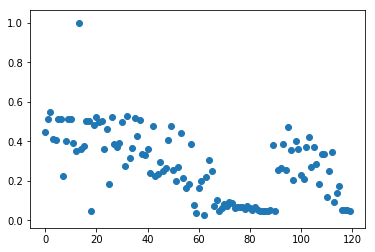

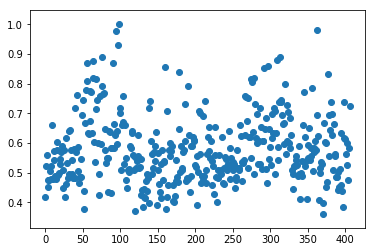

In [5]:
# zero crossing rate of frame 
zero_crossingsA = np.array([audioFeatureExtraction.stZCR(x) for x in x_dataA])
zero_crossingsA = zero_crossingsA/max(zero_crossingsA)
zero_crossingsB = np.array([audioFeatureExtraction.stZCR(x) for x in x_dataB])
zero_crossingsB = zero_crossingsB/max(zero_crossingsB)
figure()
scatter(range(0,len(x_dataA)),zero_crossingsA)
show()
figure()
scatter(range(0,len(x_dataB)),zero_crossingsB)
show()

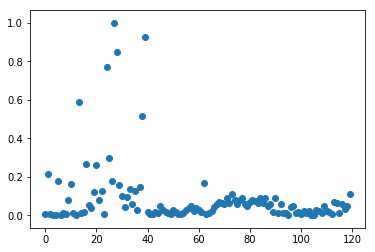

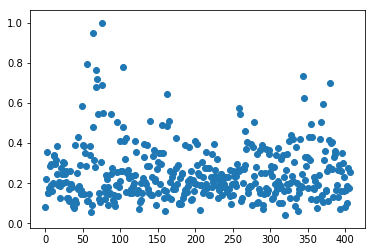

In [6]:
# signal energy of frame
energyA = np.array([audioFeatureExtraction.stEnergy(x) for x in x_dataA])
energyA = energyA/max(energyA)
energyB = np.array([audioFeatureExtraction.stEnergy(x) for x in x_dataB])
energyB = energyB/max(energyB)
figure()
scatter(range(0,len(x_dataA)),energyA)
show()
figure()
scatter(range(0,len(x_dataB)),energyB)
show()

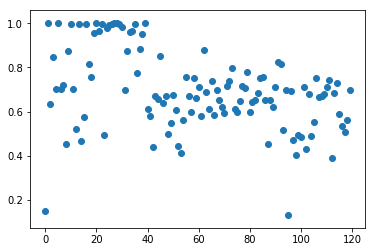

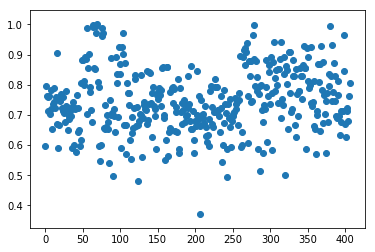

In [7]:
# entropy of energy
entropyA = np.array([audioFeatureExtraction.stEnergyEntropy(x, numOfShortBlocks=50) for x in x_dataA])
entropyA = entropyA/max(entropyA)
entropyB = np.array([audioFeatureExtraction.stEnergyEntropy(x, numOfShortBlocks=50) for x in x_dataB])
entropyB = entropyB/max(entropyB)
figure()
scatter(range(0,len(x_dataA)),entropyA)
show()
figure()
scatter(range(0,len(x_dataB)),entropyB)
show()

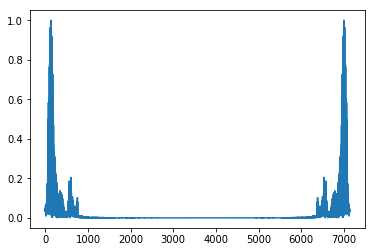

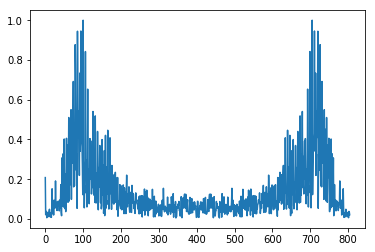

In [8]:
# frequency domain
X_dataA = np.array([np.fft.fft(x) for x in x_dataA])
X_dataA = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataA])
figure()
plot(X_dataA[70])
show()

#Xn_dataA = np.array([nfft(x,2) for x in x_dataA])
#Xn_dataA = np.array([np.abs(X)/max(np.abs(X)) for X in Xn_dataA])
#figure()
#plot(Xn_dataA[70])
#show()

X_dataB = np.array([np.fft.fft(x) for x in x_dataB])
X_dataB = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataB])
figure()
plot(X_dataB[300])
show()

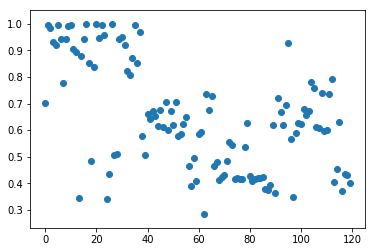

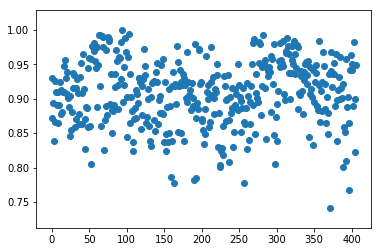

In [9]:
# spectral entropy
entropy_freqA = np.array([audioFeatureExtraction.stSpectralEntropy(X, numOfShortBlocks=150) for X in X_dataA])
entropy_freqA = entropy_freqA/max(entropy_freqA)
entropy_freqB = np.array([audioFeatureExtraction.stSpectralEntropy(X, numOfShortBlocks=150) for X in X_dataB])
entropy_freqB = entropy_freqB/max(entropy_freqB)
figure()
scatter(range(0,len(X_dataA)),entropy_freqA)
show()
figure()
scatter(range(0,len(X_dataB)),entropy_freqB)
show()

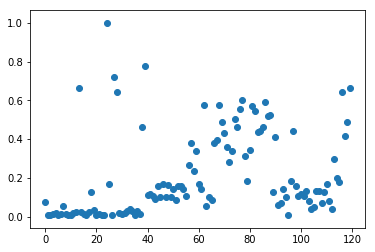

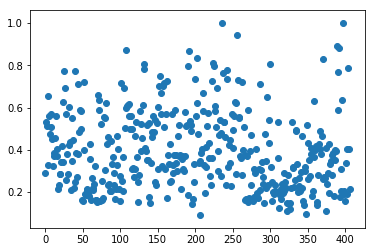

In [10]:
# spectral flux
fluxA = np.array([np.abs(audioFeatureExtraction.stSpectralFlux(X[:int(len(X)/2)], X[int(len(X)/2):])) for X in X_dataA])
fluxA = fluxA/max(fluxA)
fluxB = np.array([np.abs(audioFeatureExtraction.stSpectralFlux(X[:int(len(X)/2)], X[int(len(X)/2)+1:])) for X in X_dataB])
fluxB = fluxB/max(fluxB)
figure()
scatter(range(0,len(X_dataA)),fluxA)
show()
figure()
scatter(range(0,len(X_dataB)),fluxB)
show()

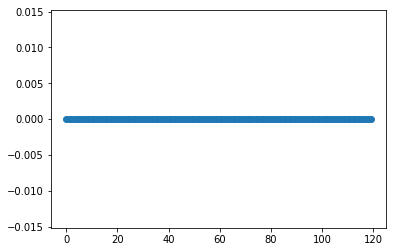

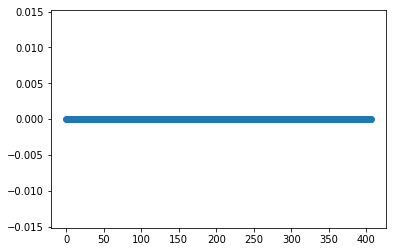

In [386]:
# spectral roll-off
c = 343 # speed of sound
FsA = int(framerate_A[0]/10) # framerate is the same for all of set A
FsB = int(framerate_B[0]/5) # framerate is the same for all of set B

rolloffA = np.array([audioFeatureExtraction.stSpectralRollOff(X,c,FsA) for X in X_dataA])
rolloffB = np.array([audioFeatureExtraction.stSpectralRollOff(X,c,FsB) for X in X_dataB])

figure()
scatter(range(0,len(X_dataA)),rolloffA)
show()
figure()
scatter(range(0,len(X_dataB)),rolloffB)
show()

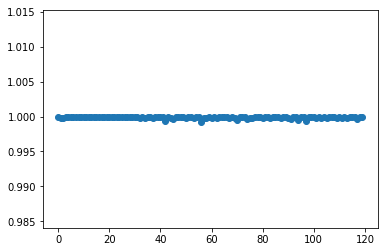

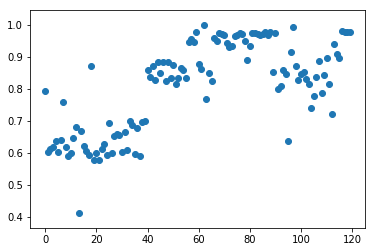

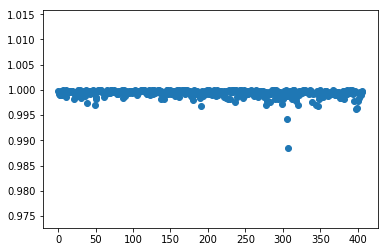

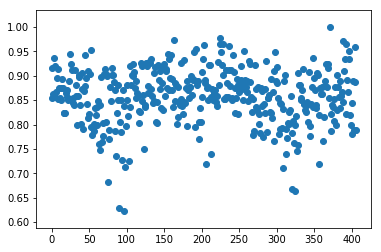

In [11]:
# spectral centroid of frame (given abs(FFT))
FsA = int(framerate_A[0]/20) # framerate is the same for all of set A
FsB = int(framerate_B[0]/10) # framerate is the same for all of set B

centroidA = np.array([audioFeatureExtraction.stSpectralCentroidAndSpread(np.abs(X),FsA) for X in X_dataA])
centroidA[:,0] = centroidA[:,0]/max(centroidA[:,0])
centroidA[:,1] = centroidA[:,1]/max(centroidA[:,1])
centroidB = np.array([audioFeatureExtraction.stSpectralCentroidAndSpread(np.abs(X),FsB) for X in X_dataB])
centroidB[:,0] = centroidB[:,0]/max(centroidB[:,0])
centroidB[:,1] = centroidB[:,1]/max(centroidB[:,1])
figure()
scatter(range(0,len(X_dataA)),centroidA[:,0]) #centroid of A
show()
figure()
scatter(range(0,len(X_dataA)),centroidA[:,1]) #spread of A
show()
figure()
scatter(range(0,len(X_dataB)),centroidB[:,0]) #centroid of B
show()
figure()
scatter(range(0,len(X_dataB)),centroidB[:,1]) #spread of B
show()

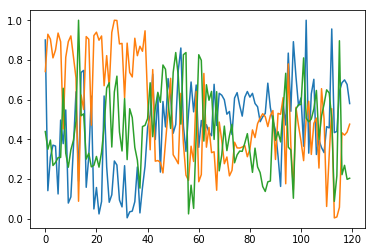

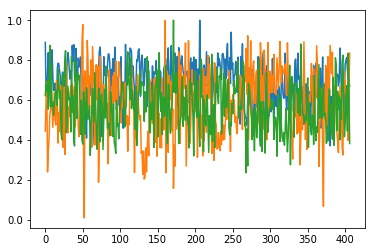

In [18]:
FsA = int(framerate_A[0]/10) # framerate is the same for all of set A
FsB = int(framerate_B[0]/10) # framerate is the same for all of set B

from python_speech_features import mfcc

mfccA = np.array([mfcc(np.abs(x),samplerate=FsA, numcep=3,winlen=0.025) for x in x_dataA])
mfccA_feat = np.array([[np.average(m[:,0]),np.average(m[:,1]),np.average(m[:,2])] for m in mfccA])
for i in range(len(mfccA_feat[0])):
    mfccA_feat[:,i] = np.abs(mfccA_feat[:,i])/max(np.abs(mfccA_feat[:,i]))

mfccB = np.array([mfcc(np.abs(x),samplerate=FsB, numcep=5,winlen=0.01, winstep=0.01) for x in x_dataB])
mfccB_feat = np.array([[np.average(m[:,0]),np.average(m[:,1]),np.average(m[:,2])] for m in mfccB])
for i in range(len(mfccB_feat[0])):
    mfccB_feat[:,i] = np.abs(mfccB_feat[:,i])/max(np.abs(mfccB_feat[:,i]))

figure()
plot(mfccA_feat)
show()
figure()
plot(mfccB_feat)
show()

In [19]:
# features to use
# zero_crossings, energy, entropy, entropy frequency, flux, spread, mfcc
x_trainA = np.column_stack((zero_crossingsA, energyA, entropyA, entropy_freqA, fluxA, centroidA[:,1],mfccA_feat))
x_trainB = np.column_stack((zero_crossingsB, energyB, entropyB, entropy_freqB, fluxB, centroidB[:,1],mfccB_feat))
print(x_trainA.shape)
print(x_trainB.shape)

(120, 9)
(407, 9)


In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_trainA = le.fit_transform(y_labelA) # 0 - artifact, 1 - extrahls, 2 - murmur, 3 - normal
y_trainB = le.fit_transform(y_labelB)
print(y_trainA.shape)
print(y_trainB.shape)

(120,)
(407,)


In [84]:
# shuffle data and test/train split 
from sklearn.model_selection import ShuffleSplit
rsA = ShuffleSplit(n_splits=5, test_size=.25, random_state=5) #2, 5
rsA.get_n_splits(x_trainA)
rsB = ShuffleSplit(n_splits=5, test_size=.25, random_state=1)
rsB.get_n_splits(x_trainB)

5

In [22]:
# classifier
from sklearn import tree
resultsA_dt = []
for train_index, test_index in rsA.split(x_trainA):
    clfA = tree.DecisionTreeClassifier()
    resultsA_dt.append(clfA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_dt)

resultsB_dt = []
for train_index, test_index in rsB.split(x_trainB):
    clfB = tree.DecisionTreeClassifier()
    resultsB_dt.append(clfB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_dt)

[0.66666666666666663, 0.66666666666666663, 0.6333333333333333, 0.6333333333333333, 0.66666666666666663]
[0.51960784313725494, 0.52941176470588236, 0.60784313725490191, 0.62745098039215685, 0.53921568627450978]


In [23]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
resultsA_ada = []
for train_index, test_index in rsA.split(x_trainA):
    adaA = AdaBoostClassifier()
    resultsA_ada.append(adaA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_ada)

resultsB_ada = []
for train_index, test_index in rsB.split(x_trainB):
    adaB = AdaBoostClassifier()
    resultsB_ada.append(adaB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_ada)

[0.5, 0.59999999999999998, 0.69999999999999996, 0.29999999999999999, 0.59999999999999998]
[0.62745098039215685, 0.59803921568627449, 0.63725490196078427, 0.55882352941176472, 0.6470588235294118]


In [24]:
from sklearn.naive_bayes import GaussianNB
resultsA_gnb = []
for train_index, test_index in rsA.split(x_trainA):
    gnbA = GaussianNB()
    resultsA_gnb.append(gnbA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_gnb) 

resultsB_gnb = []
for train_index, test_index in rsB.split(x_trainB):
    gnbB = GaussianNB()
    resultsB_gnb.append(gnbA.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_gnb) 

[0.69999999999999996, 0.6333333333333333, 0.69999999999999996, 0.80000000000000004, 0.73333333333333328]
[0.58823529411764708, 0.50980392156862742, 0.49019607843137253, 0.51960784313725494, 0.56862745098039214]


In [42]:
resultsA_gb = []
for train_index, test_index in rsA.split(x_trainA):
    gbA = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100)
    resultsA_gb.append(gbA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_ada)

resultsB_gb = []
for train_index, test_index in rsB.split(x_trainB):
    gbB = GradientBoostingClassifier()
    resultsB_gb.append(gbB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_ada)

[0.5, 0.59999999999999998, 0.69999999999999996, 0.29999999999999999, 0.59999999999999998]
[0.62745098039215685, 0.59803921568627449, 0.63725490196078427, 0.55882352941176472, 0.6470588235294118]


In [26]:
from sklearn.svm import SVC
resultsA_svm = []
for train_index, test_index in rsA.split(x_trainA):
    svmA = SVC(C=10)
    resultsA_svm.append(svmA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index], y_trainA[test_index]))
print(resultsA_svm)

resultsB_svm = []
for train_index, test_index in rsA.split(x_trainB):
    svmB = SVC(C=10)
    resultsB_svm.append(svmB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index], y_trainB[test_index]))
print(resultsB_svm)

[0.6333333333333333, 0.69999999999999996, 0.76666666666666672, 0.56666666666666665, 0.66666666666666663]
[0.68627450980392157, 0.59803921568627449, 0.71568627450980393, 0.72549019607843135, 0.65686274509803921]


In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

# NB - 60, 5 --> 72.5%
seed = 26 #26
kfold = model_selection.KFold(n_splits=60, random_state=seed)
cart = GaussianNB()
model = BaggingClassifier(base_estimator=cart,n_estimators=5,random_state=seed)
results = model_selection.cross_val_score(model, x_trainA, y_trainA, cv=kfold)
print(results.mean())

0.716666666667


In [85]:
#adaboost with naive bayes
resultsA_adaNB = []
for train_index, test_index in rsA.split(x_trainA):
    gnbA = GaussianNB()
    adaNBA = AdaBoostClassifier(base_estimator=gnbA, learning_rate=0.001, n_estimators=50)
    resultsA_adaNB.append(adaNBA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    print(y_trainA[test_index])
print(resultsA_adaNB)

resultsB_adaNB = []
for train_index, test_index in rsB.split(x_trainB):
    gnbB = GaussianNB()
    adaNBB = AdaBoostClassifier(base_estimator=gnbB, learning_rate=0.01, n_estimators=100)
    resultsB_adaNB.append(adaNBB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_adaNB)

[2 2 0 0 3 0 2 1 2 2 0 0 0 2 2 0 3 2 3 3 0 1 1 2 0 1 3 3 3 1]
[3 0 3 3 2 3 0 2 2 2 1 2 2 3 1 3 0 2 0 2 1 3 2 0 0 0 1 3 1 1]
[1 2 2 2 1 2 2 0 0 2 1 3 0 0 2 1 0 0 0 0 3 1 0 2 2 0 2 0 0 2]
[0 2 2 1 0 0 1 2 3 3 0 3 3 2 1 3 0 0 0 0 0 3 3 2 2 0 0 2 3 0]
[2 0 3 1 1 1 3 0 2 1 0 1 2 0 0 2 2 0 0 3 3 3 3 3 2 2 3 3 0 0]
[0.73333333333333328, 0.73333333333333328, 0.83333333333333337, 0.73333333333333328, 0.69999999999999996]
[0.65686274509803921, 0.58823529411764708, 0.63725490196078427, 0.66666666666666663, 0.65686274509803921]


In [341]:
from sklearn.ensemble import RandomForestClassifier
seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, x_trainA, y_trainA, cv=kfold)
print(results.mean())

0.608333333333
